# Classification Binaire Sans Rééchantillonnage (Partie 1)
Simulations en faisant varier les principaux paramètres

## Import des librairies

In [3]:
# !pip install geopandas
# !pip install --upgrade matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from datetime import datetime, timezone, timedelta
from sklearn.metrics import confusion_matrix, classification_report
# import geopandas
from sklearn.linear_model import LinearRegression, LogisticRegression

from scipy.stats import chi2_contingency

# Import des librairies bokeh
from bokeh.models import ColumnDataSource, GeoJSONDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import row,column
from bokeh.io import push_notebook,output_notebook, show
output_notebook()  # pour un affichage dans le notebook

Loading BokehJS ...

##Chargement du fichier avec les variables issues de la phase preprocessing

In [6]:
# df_final = pd.read_csv(path, index_col=0)
df_final = pd.read_csv("C:\workspaces\Datascientest\MonProjetMeteo\data\weatherAUS_Kapy_v2_20230708.csv",
                       index_col=0,parse_dates=[1])

In [7]:
# Affichage du nombre de valeurs restantes avec un dropna
df_final.dropna(inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    119115 non-null  datetime64[ns]
 1   Location                119115 non-null  object        
 2   Rainfall                119115 non-null  float64       
 3   WindGustSpeed           119115 non-null  float64       
 4   Temp9am                 119115 non-null  float64       
 5   RainTomorrow            119115 non-null  float64       
 6   DayOfYear               119115 non-null  int64         
 7   Month                   119115 non-null  int64         
 8   Latitude                119115 non-null  float64       
 9   Longitude               119115 non-null  float64       
 10  diffWind3pm9am          119115 non-null  float64       
 11  diffTempMinMax          119115 non-null  float64       
 12  diffPressure9am3pm      119115

##Suppression de quelques variables non utilisées

In [8]:
# suppression du lieu, et des coord géographiques
df = df_final.drop(['Date','Location','Latitude','Longitude'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall                119115 non-null  float64
 1   WindGustSpeed           119115 non-null  float64
 2   Temp9am                 119115 non-null  float64
 3   RainTomorrow            119115 non-null  float64
 4   DayOfYear               119115 non-null  int64  
 5   Month                   119115 non-null  int64  
 6   diffWind3pm9am          119115 non-null  float64
 7   diffTempMinMax          119115 non-null  float64
 8   diffPressure9am3pm      119115 non-null  float64
 9   Pressure                119115 non-null  float64
 10  DeltaP_1d               119115 non-null  float64
 11  DeltaP_2d               119115 non-null  float64
 12  DeltaP_3d               119115 non-null  float64
 13  diffHimidity9am3pm      119115 non-null  float64
 14  Humidity            

## **Jeu de données peu équilibré**

La target binaire n'est pas équilibrée. La valeur true ne représente que 22% de toutes les valeurs. Dans un premier temps, nous travaillons sur le jeu de données tel quel.

In [9]:
len(df[df["RainTomorrow"]==True])/len(df)

0.2190907946102506

# Jeu de données d'entrainement et de test

In [10]:
# séparation en features et target
target = df["RainTomorrow"]
features = df.drop("RainTomorrow",axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall                119115 non-null  float64
 1   WindGustSpeed           119115 non-null  float64
 2   Temp9am                 119115 non-null  float64
 3   DayOfYear               119115 non-null  int64  
 4   Month                   119115 non-null  int64  
 5   diffWind3pm9am          119115 non-null  float64
 6   diffTempMinMax          119115 non-null  float64
 7   diffPressure9am3pm      119115 non-null  float64
 8   Pressure                119115 non-null  float64
 9   DeltaP_1d               119115 non-null  float64
 10  DeltaP_2d               119115 non-null  float64
 11  DeltaP_3d               119115 non-null  float64
 12  diffHimidity9am3pm      119115 non-null  float64
 13  Humidity                119115 non-null  float64
 14  DeltaH_1d           

In [11]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import confusion_matrix

In [12]:
# séparation en jeux d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state = 42, shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(pd.DataFrame(y_test).value_counts())

(95292, 28)
(23823, 28)
RainTomorrow
0.0             18590
1.0              5233
dtype: int64


# **Normalisation des données**

Nous allons utiliser un preprocessing de normalisation MinMax.

La normalisation MinMax effectue le calcul suivant sur chaque variable :

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

Les valeurs des variables sont donc ramenées entre 0 et 1.



In [13]:
from sklearn.preprocessing import MinMaxScaler

# pour plus d'info, voir : https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

minmax = MinMaxScaler()

X_train_minmax = minmax.fit_transform(X_train,y_train)

X_test_minmax = minmax.transform(X_test)

pd.DataFrame(X_train_minmax).describe().transpose().mean()

count    95292.000000
mean         0.321393
std          0.171141
min          0.000000
25%          0.226067
50%          0.279766
75%          0.409257
max          1.000000
dtype: float64

# **Modèle "Désertique" qui prédit qu'il ne pleut jamais**

Un modèle qui prédirait qu'il ne pleut jamais aurait cette matrice de confusion :

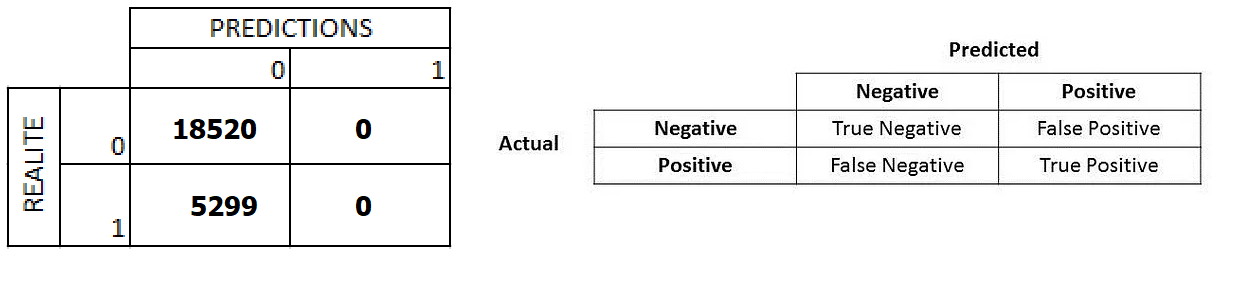

**Et donc les éléments suivants :**

Accuracy = (TP+TN)/(TP+FP+FN+TN) ==> 0.7775305428439481

Recall = TP/(TP+FN) ==> 0.0

Specificity = TN/(TN+FP) ==> 1.0

le F1-Score et la Precision ne peuvent être calculés ici (division par 0)

Ce modèle "désertique" a déjà une accuracy de plus de 77% mais un rappel de 0.


**L'Accuracy n'est donc pas le seul élément déterminant, car même pour le modèle "Désertique", on obtient déjà 77% de bonnes prédictions.**

In [14]:
def Accuracy(TP,TN,FP,FN):
    return (TP+TN)/(TP+FP+FN+TN)

def Precision(TP,FP):
    return TP/(TP+FP)

def Recall(TP,FN):
    return TP/(TP+FN)

def F1score(Recall,Precision):
    return 2*(Recall * Precision) / (Recall + Precision)

def Specificity(TN,FP):
    return TN/(TN+FP)


TP=0
TN = 18520
FN = 5299
FP = 0

print("Accuracy = (TP+TN)/(TP+FP+FN+TN) ==>",Accuracy(TP,TN,FP,FN))
# print("Precision = TP/(TP+FP) ==>",Precision(TP,FP))
print("Recall = TP/(TP+FN) ==>",Recall(TP,FN))
# print("F1 Score = 2*(Recall * Precision) / (Recall + Precision) ==>",F1score(Recall(TP,FN),Precision(TP,FP)))
print("Specificity = TN/(TN+FP) ==>",Specificity(TN,FP))


Accuracy = (TP+TN)/(TP+FP+FN+TN) ==> 0.7775305428439481
Recall = TP/(TP+FN) ==> 0.0
Specificity = TN/(TN+FP) ==> 1.0


# **Modèle "Parfait" qui prédit la pluie**

Ce modèle parfait aurait cette matrice de confusion :
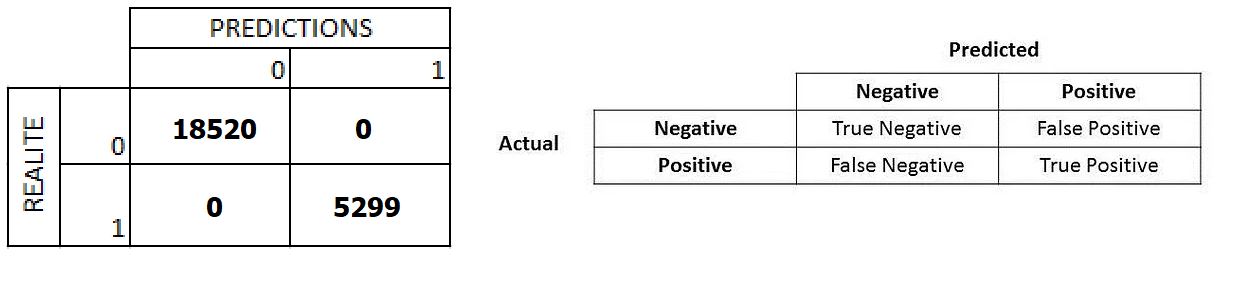



**Et donc les éléments suivants :**

Accuracy = (TP+TN)/(TP+FP+FN+TN) = 1.0

Precision = TP/(TP+FP) = 1.0

Recall = TP/(TP+FN) = 1.0

F1-Score = 2*(Recall * Precision) / (Recall + Precision) = 1.0

Specificity = TN/(TN+FP) = 1.0

**Notre objectif est donc de faire tendre vers 1** : l'Accuracy, la Precision, le Recall( rappel), le F1-Score et la Specificity.

In [15]:
TP= 5299
TN = 18520
FN = 0
FP = 0

print("Accuracy = (TP+TN)/(TP+FP+FN+TN) ==>",Accuracy(TP,TN,FP,FN))
print("Precision = TP/(TP+FP) ==>",Precision(TP,FP))
print("Recall = TP/(TP+FN) ==>",Recall(TP,FN))
print("F1 Score = 2*(Recall * Precision) / (Recall + Precision) ==>",F1score(Recall(TP,FN),Precision(TP,FP)))
print("Specificity = TN/(TN+FP) ==>",Specificity(TN,FP))

Accuracy = (TP+TN)/(TP+FP+FN+TN) ==> 1.0
Precision = TP/(TP+FP) ==> 1.0
Recall = TP/(TP+FN) ==> 1.0
F1 Score = 2*(Recall * Precision) / (Recall + Precision) ==> 1.0
Specificity = TN/(TN+FP) ==> 1.0


# KNN sur RainTomorrow binaire

Nous commençons par tester un modèle simple sur KNN afin de prédire la variable binaire RainTomorrow.


# Première simulation

In [16]:
# Première simulation sur le jeu de données normalisées

from sklearn.neighbors import KNeighborsClassifier

hdebut = datetime.now()
print("heure de début KNN sur X_train_minmax:",hdebut)
# initialisation du modèle modèle :
knn = KNeighborsClassifier(n_neighbors = 2, weights = "uniform", algorithm = "auto", leaf_size = 30, p = 2, 
                           metric = "minkowski", metric_params = None, n_jobs = None)

knn.fit(X_train_minmax,y_train)

y_predict = knn.predict(X_test_minmax)
hfin = datetime.now()
print("heure de fin KNN sur X_train_minmax + calcul de y_predict:",hfin)
print("durée du traitement :", hfin-hdebut)

heure de début KNN sur X_train_minmax: 2023-07-14 18:47:02.069996
heure de fin KNN sur X_train_minmax + calcul de y_predict: 2023-07-14 18:47:03.483834
durée du traitement : 0:00:01.413838


In [17]:
from pandas.core.arrays.timedeltas import precision_from_unit
print(pd.crosstab(y_test,y_predict,rownames=['Realité'],colnames=['Prédiction']))

TP = pd.crosstab(y_test,y_predict,rownames=['Realité'],colnames=['Prédiction']).iloc[1,1]
TN = pd.crosstab(y_test,y_predict,rownames=['Realité'],colnames=['Prédiction']).iloc[0,0]
FP = pd.crosstab(y_test,y_predict,rownames=['Realité'],colnames=['Prédiction']).iloc[0,1]
FN = pd.crosstab(y_test,y_predict,rownames=['Realité'],colnames=['Prédiction']).iloc[1,0]

print("\n")
print("TP",TP)
print("TN",TN)
print("FP",FP)
print("FN",FN)

Prédiction    0.0   1.0
Realité                
0.0         17994   596
1.0          3090  2143


TP 2143
TN 17994
FP 596
FN 3090


In [18]:
print("Accuracy = (TP+TN)/(TP+FP+FN+TN) ==>",Accuracy(TP,TN,FP,FN))
print("Precision = TP/(TP+FP) ==>",Precision(TP,FP))
print("Recall = TP/(TP+FN) ==>",Recall(TP,FN))
print("F1 Score = 2*(Recall * Precision) / (Recall + Precision) ==>",F1score(Recall(TP,FN),Precision(TP,FP)))
print("Specificity = TN/(TN+FP) ==>",Specificity(TN,FP))

Accuracy = (TP+TN)/(TP+FP+FN+TN) ==> 0.8452755740251018
Precision = TP/(TP+FP) ==> 0.7824023366192041
Recall = TP/(TP+FN) ==> 0.4095165297152685
F1 Score = 2*(Recall * Precision) / (Recall + Precision) ==> 0.5376317109884596
Specificity = TN/(TN+FP) ==> 0.9679397525551372


###Commentaires sur cette première simulation KNN

L'accuracy est de 84.52% > 77% du modèle "Désertique".

Par contre, le F1-Score (53%) et le Recall (40.9%) sont assez bas.

##Simulations en variant les valeurs des paramètres

Avec toujours ce même jeu de données, nous allons faire varier dans nos simulations le nombre de voisins ainsi que le type de 'distance' utilisée.

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


params = {}
params['nb_voisins'] = np.arange(2,51,1)
params['metric'] = ['l1','l2','manhattan','nan_euclidean','minkowski','chebyshev','cityblock','cosine','euclidean']
# 'haversine' ==> valide seulement en 2D
params['weights'] = ['uniform','distance']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
            #initialisation du modèle modèle :
            knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
        
            knn.fit(X_train_minmax,y_train)
            
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

chemin_local = 'C:/workspaces/Datascientest/MonProjetMeteo/data/'

nom_fichier = 'accuracy_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
temps_traitement.append(["Durée sauvegarde",hsav - hfin])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=50--metric=euclidean--weights=distance'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_2788\80852067.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_2788\80852067.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_2788\80852067.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

Type                      Valeur
0  Début traitement  2023-07-08 18:07:09.772407
1    Fin traitement  2023-07-09 01:35:32.542728
2  Durée traitement              7:28:22.770321
3    Fin sauvegarde  2023-07-09 01:36:14.307487
4  Durée sauvegarde              0:00:41.764759

In [4]:
# charger les indicateurs

# from google.colab import drive
# drive.mount('/content/drive')
chemin_local = 'C:\workspaces\Datascientest\MonProjetMeteo\data\\'

# chemin_local = 'https://github.com/Mediapax/Data/raw/main/'

nom_fichier = 'accuracy_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

# 611+ Mo ==> imposible de charger depuis le compte github :
# "Yowza, that’s a big file. Try again with a file smaller than 25MB."
# nom_fichier = 'y_predict_v1.0.csv'
# y_predict_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

# 611+ Mo ==> imposible de charger depuis le compte github :
# "Yowza, that’s a big file. Try again with a file smaller than 25MB."
# print(y_predict_v1.head(15))
# print("\n")

print(crosstab_v1.head(15))

    k         metric   weights    valeur   evaluateur
0   2             l1   uniform  0.848214  accuracy_v1
1   2             l1  distance  0.841414  accuracy_v1
2   2             l2   uniform  0.845276  accuracy_v1
3   2             l2  distance  0.835747  accuracy_v1
4   2      manhattan   uniform  0.848214  accuracy_v1
5   2      manhattan  distance  0.841414  accuracy_v1
6   2  nan_euclidean   uniform  0.845276  accuracy_v1
7   2  nan_euclidean  distance  0.835747  accuracy_v1
8   2      minkowski   uniform  0.845276  accuracy_v1
9   2      minkowski  distance  0.835747  accuracy_v1
10  2      chebyshev   uniform  0.834530  accuracy_v1
11  2      chebyshev  distance  0.819460  accuracy_v1
12  2      cityblock   uniform  0.848214  accuracy_v1
13  2      cityblock  distance  0.841414  accuracy_v1
14  2         cosine   uniform  0.844562  accuracy_v1


    k         metric   weights    valeur    evaluateur
0   2             l1   uniform  0.802922  precision_v1
1   2             l1  di

###Graphiques de présentation des résultats

In [5]:
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}
params['nb_voisins'] = np.arange(2,51,1)
params['metric'] = ['l1','l2','manhattan','nan_euclidean','minkowski','chebyshev','cityblock','cosine','euclidean']
# 'haversine' ==> valide seulement en 2D
params['weights'] = ['uniform','distance']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=600,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(17 * (acc_f1['accuracy'] * acc_f1['f1score']**2),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


###Résultats obtenus

Les meilleurs compromis entre Accuracy et F1-Score semblent être obtenus avec les valeurs suivantes :

-1) 
F1-Score : 0.641
Accuracy : 0.866
Recall : 0.545
Precision : 0.780
Specificity : 0.957
k = 8
Metric = Manhattan ou L1 ou Cityblock
Weights = Distance

-2) 
F1-Score : 0.648
Accuracy : 0.866
Recall : 0.561
Precision : 0.766
Specificity : 0.952
k = 6
Metric = Manhattan ou L1 ou Cityblock
Weights = Distance

-3) 
F1-Score : 0.642
Accuracy : 0.864
Recall : 0.556
Precision : 0.761
Specificity : 0.951
k = 5
Metric = Manhattan ou L1 ou Cityblock
Weights = Distance

-4) 
F1-Score : 0.650
Accuracy : 0.862
Recall : 0.586
Precision : 0.731
Specificity : 0.939
k = 4
Metric = Manhattan ou L1 ou Cityblock
Weights = Distance

-5) 
F1-Score : 0.645
Accuracy : 0.860
Recall : 0.579
Precision : 0.728
Specificity : 0.939
k = 3
Metric = Manhattan ou L1 ou Cityblock
Weights = Distance

-6) 
F1-Score : 0.642
Accuracy : 0.859
Recall : 0.575
Precision : 0.726
Specificity : 0.939
k = 3
Metric = Manhattan ou L1 ou Cityblock
Weights = Uniform


L'Accuracy optimale est autour de 86% (Pour rappel, le **Modèle "Désertique" qui prédit qu'il ne pleut jamais** a une accuracy de 77%...). Ici, C'est le F1-Score qui sera notre principal indicateur.